In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'crm' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/1/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/1/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004' # Updated 1/1/21
               , 'ibm': '01/02/1962' # Updated 1/1/21
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000' # Updated 1/1/21
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986' # Updated 1/1/21
               , 'nio': '09/10/2018' # Updated 1/1/21
               , 'nvda': '01/22/1999' # Updated 1/1/21
               , 'pypl': '07/05/2015' # Updated 1/1/21
               , 'tsla': '06/29/2010' # Updated 1/1/21
               , 'v': '03/16/2008' # Updated 1/1/21
               , 'vbiv': '09/04/2002' # Updated 1/1/21
               , 'vgt': '01/26/2004' # Updated 1/1/21
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,226.729996,224.500000,224.899994,225.919998,9946900.0,225.919998,-0.004535,0.009933,0.010285,0.009680,0.002714,-1
2020-12-18,227.820007,224.399994,227.020004,227.429993,11845400.0,227.429993,-0.001806,0.015241,0.006684,0.009354,0.004500,-1
2020-12-21,227.440002,224.710007,224.899994,226.470001,9219000.0,226.470001,-0.006981,0.012149,-0.004221,0.009116,0.004690,-1
2020-12-22,231.869995,226.600006,227.000000,231.169998,10339600.0,231.169998,-0.018370,0.023257,0.020753,0.009514,0.009853,-1
2020-12-23,233.179993,227.110001,232.500000,227.429993,7090500.0,227.429993,0.021806,0.026727,-0.016179,0.014148,0.003465,1
2020-12-24,229.190002,224.830002,228.300003,225.779999,6146300.0,225.779999,0.011038,0.019392,-0.007255,0.014209,-0.000044,-1
2020-12-28,227.839996,222.050003,227.220001,224.639999,6422500.0,224.639999,0.011355,0.026075,-0.005049,0.013782,-0.002390,-1
2020-12-29,225.300003,220.860001,224.970001,222.460007,6122400.0,222.460007,0.011157,0.020103,-0.009704,0.014177,-0.003487,-1
2020-12-30,223.639999,221.580002,223.130005,222.399994,4724000.0,222.399994,0.003272,0.009297,-0.000270,0.005881,-0.007691,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.71763932 0.71763932 0.71763932]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

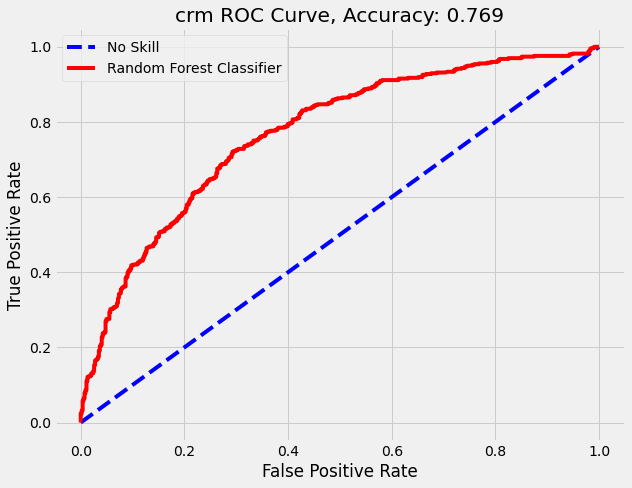

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

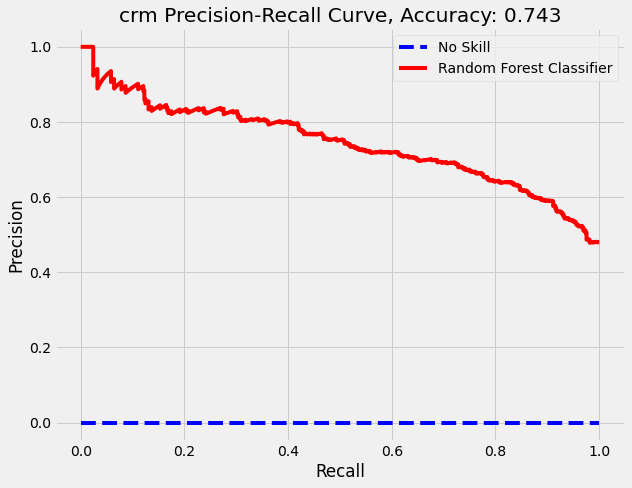

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

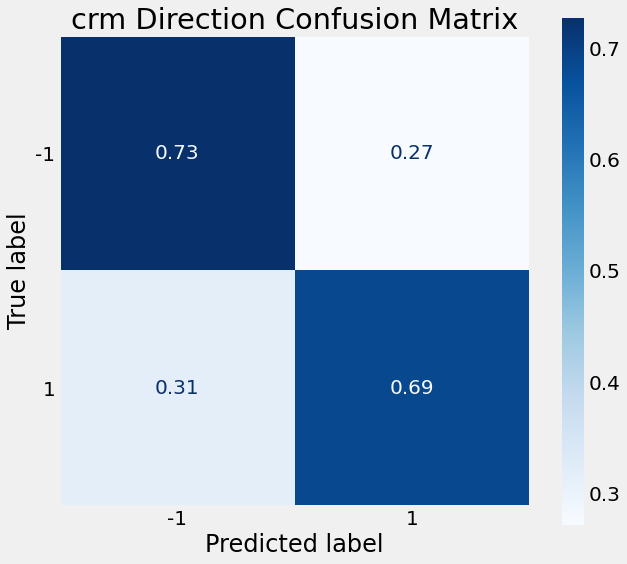

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.711089222901046'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.227900e+02
Low           2.201700e+02
Open          2.222700e+02
Close         2.225300e+02
Volume        6.005800e+06
Adj Close     2.225300e+02
oc           -1.169724e-03
hl            1.189987e-02
adj           5.845543e-04
5stdev_adj    4.432676e-03
5sma_adj     -4.338742e-03
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.001170
hl            0.011900
5stdev_adj    0.004433
5sma_adj     -0.004339
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    4157.000000
mean        0.001330
std         0.027227
min        -0.271482
25%        -0.011603
50%         0.000567
75%         0.013868
max         0.260449
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy crm


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,229.190002,224.830002,228.300003,225.779999,6146300.0,225.779999,0.011038,0.019392,-0.007255,0.014209,-0.000044,-1,1,-0.005049
2020-12-28,227.839996,222.050003,227.220001,224.639999,6422500.0,224.639999,0.011355,0.026075,-0.005049,0.013782,-0.002390,-1,1,-0.009704
2020-12-29,225.300003,220.860001,224.970001,222.460007,6122400.0,222.460007,0.011157,0.020103,-0.009704,0.014177,-0.003487,-1,1,-0.000270
2020-12-30,223.639999,221.580002,223.130005,222.399994,4724000.0,222.399994,0.003272,0.009297,-0.000270,0.005881,-0.007691,-1,1,0.000585
2020-12-31,222.789993,220.169998,222.270004,222.529999,6005800.0,222.529999,-0.001170,0.011900,0.000585,0.004433,-0.004339,-1,1,0.000567


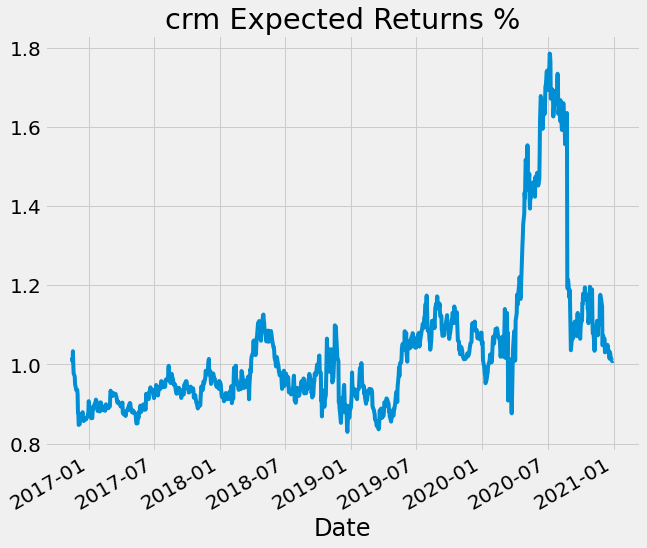

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.0050603310074813

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

12.423616768054432

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/